# LIM forecasting: multivariate separate sic each month

Katie Brennan  
started May 2021  
  
#### Goals: 
* Build LIM with all months 
* Validate on: different model output, satellite data, historical simulations

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [2]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [3]:
import importlib
importlib.reload(limkb)
importlib.reload(statskb)
importlib.reload(limbuild)

<module 'LIM_building' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py'>

In [4]:
# %load_ext autoreload
# %autoreload 2

In [5]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [6]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

In [7]:
# number of EOFs to retain for the LIM state vector
ntrunc = 30 # EOF truncation for individual fields (reduced-state space)
nmodes = 30 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

mo='all'
#mo=0

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 0.3
ntraintimes = 1872
# nvalidtimes = 1872
nttrain_valid = 1

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
#limvars = ['tas','tos','psl','sit','sic']
limvars = ['tas','tos','sic']
limvars_nosic = ['tas','tos']
nvars = len(limvars)

# specify the model source 
train_dsource = 'mpi_lm_kb'
#train_dsource = 'ccsm4_lm_kb'
valid_dsource = 'mpi_hist_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True
Insamp = False

In [8]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_train = limkb.build_training_dic(train_dsource)
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names()
areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train, remove_climo=False, 
                                                      detrend=False, verbose=False )

Loading from lla_fx_MPI-ESM-P_past1000_r0i0p0.nc
Loading from llo_fx_MPI-ESM-P_past1000_r0i0p0.nc


In [ ]:
wt=True
var_dict = {}


for k, var in enumerate(['tas']): 
    X_var, var_dict = limkb.load_data(var, var_dict, fdic_train, remove_climo=True, 
                                      detrend=True, verbose=True)
    
    #x_var = X_var[70*12:110*12,:,:]
    
    tsamp = X_var.shape[1]
    
    acell = areacell[areawt_name[var]]
    if len(acell.shape)>1:
        acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
    else: 
        acell_1d = acell
     
    [Ptrunc, E3, tot_var,
     tot_var_eig, W_all, 
     standard_factor, vexp] = limkb.step1_compress_individual_var(X_var, var, ntrunc, nmodes_sic, 
                                                            var_dict, areawt=acell_1d,
                                                            wt=wt, sic_separate=False)

Loading from tas
Loading from MPI-ESM-P_past1000_085001-184912.nc
removing climotology...
detrending...
(18432, 12000)
(18432, 12000)
-----------------------------------------------------
completed in 30.924826622009277 seconds
-----------------------------------------------------
truncating to 30


In [ ]:
vexp, standard_factor

In [ ]:
var_expl_by_retained

In [11]:
var = 'tas'
var_dict = {}

X_var, var_dict = limkb.load_data(var, var_dict, fdic_train, remove_climo=True, 
                                  detrend=True, verbose=True)

Loading tas
removing climotology...
detrending...
(18432, 12000)
(18432, 12000)
-----------------------------------------------------
completed in 18.798924446105957 seconds
-----------------------------------------------------


In [12]:
tsamp = X_var.shape[1]
    
acell = areacell[areawt_name[var]]
if len(acell.shape)>1:
    acell_1d = np.reshape(acell,(acell.shape[0]*acell.shape[1]))
else: 
    acell_1d = acell

In [13]:
trunc = ntrunc
areawt=acell_1d
wt=True

if len(var_dict[var]['lat'].shape)<2:
    nlon = var_dict[var]['lon'].shape[0]
    nlat = var_dict[var]['lat'].shape[0]
    lat = var_dict[var]['lat'][:,np.newaxis]*np.ones((nlat,nlon))
else: 
    lat = var_dict[var]['lat']

In [17]:
[eofs_out, svals_out, pcs_out, 
 tot_var, tot_var_eig, 
 var_expl_by_retained, W] = limkb.eof_decomp_1var(X_var,lat,var_dict[var]['var_ndof'],
                                                X_var.shape[1],trunc,areawt=areawt,Weight=wt)
W_all = np.squeeze(W)

# Projection
P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_var))

In [ ]:
# [eofs_out, svals_out, pcs_out, 
#  tot_var, tot_var_eig, 
#  var_expl_by_retained, W] = limkb.eof_decomp_1var(X_var,lat,var_dict[var]['var_ndof'],
#                                                   X_var.shape[1],trunc,areawt=areawt,Weight=wt)

# #W_all = 0

# # Projection
# P_var = np.matmul(eofs_out.T,np.nan_to_num(X_var))

In [18]:
print('fraction in first '+str(ntrunc)+ ' '+var+' EOFs = '+str(var_expl_by_retained))

fraction in first 30 tas EOFs = 57.770591786397475


In [19]:
ntime = X_var.shape[1]
standard_factor1 = np.sqrt((np.sum(np.var(P_var,axis=1))))
standard_factor2 = (np.sum(np.var(P_var,axis=1)))
standard_factor3 = np.sqrt(np.sum(svals_out*svals_out))/(ntime-1)
Ptrunc1 = P_var/standard_factor1
Ptrunc2 = P_var/standard_factor2
Ptrunc3 = P_var/standard_factor3

In [ ]:
plt.plot(Ptrunc1[0,:])

In [21]:
np.sum(np.var(Ptrunc1,axis=1)), np.sum(np.var(Ptrunc2,axis=1)),np.sum(np.var(Ptrunc3,axis=1))

(0.9999999999999999, 8.424674219052959e-26, 11845.023199216725)

In [23]:
int(X_var.shape[1]*ntrain)

3600

In [46]:
var_dict['tas'].keys()

dict_keys(['lat', 'lon', 'time', 'var_ndof', 'var_inds'])

## Build L from scratch: 

### Load pre-truncated training data: 

In [169]:
## Start with full training data: 
# [Ptrunc, Ptrunc_valid, E3, tot_var, 
#  tot_var_eig, W_all,standard_factor, nyears_train, 
#  var_dict] = limbuild.load_training_valid_data_full(limvars, fdic_train, mo, areacell, ntrain, 
#                                                     areawt_name, ntrunc, nmodes_sic, 
#                                                     sic_separate=sic_separate,
#                                                     remove_climo=True,detrend=True, 
#                                                     wt=True, verbose=True)

limvars = ['tas', 'tos', 'sic']

# Start with truncated training data: 
mod_folder = 'truncated_model_data/'
#mod_folder = 'truncated_model_data/'
#mod_filename = '_ntrunc30_mpi_lm_kb_20210503.pkl'
mod_filename = '_ntrunc30_mpi_hist_kb_20210507_ntrain1_standtest.pkl'
#mod_filename = '_ntrunc30_mpi_lm_kb_20210507_ntrain0_3_standtest.pkl'
#mod_sic_filename = '_ntrunc50_mpi_lm_kb_20210406.pkl'
mod_sic_filename = '_ntrunc50_mpi_hist_kb_20210507_ntrain1_standtest.pkl'
#mod_sic_filename = '_ntrunc50_mpi_lm_kb_20210507_ntrain0_3_standtest.pkl'

[Ptrunc, _, E3, tot_var, 
 tot_var_eig, W_all, standard_factor, 
 nyears_train, var_dict] = limbuild.load_training_data_truncated(limvars, mod_folder, mod_sic_filename, 
                                                                 mod_filename, mo, 1)

var_dict = limbuild.get_var_incices(limvars, var_dict)

Loading truncated tas
Loading truncated tos
Loading truncated sic
working on tas
working on tos
working on sic


In [140]:

var_dict['tas'].keys()

dict_keys(['lat', 'lon', 'time', 'var_ndof', 'var_inds'])

In [141]:
 np.sum(np.var(Ptrunc['sic'],axis=1)),np.sum(np.var(Ptrunc['tas'],axis=1)), np.sum(np.var(Ptrunc['tos'],axis=1)), np.sum(np.var(Ptrunc['sic'],axis=1))

(1.0, 1.0000000000000002, 1.0000000000000002, 1.0)

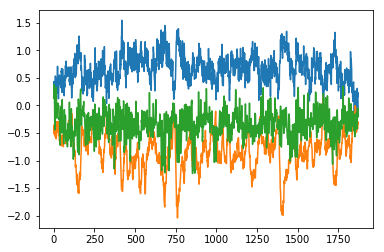

In [142]:
plt.plot(Ptrunc['tas'][0,:])
plt.plot(Ptrunc['tos'][0,:])
plt.plot(Ptrunc['sic'][0,:])

In [143]:
ndof_all = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

[Ptrunc_all, E3_all, 
Ptrunc_sic,E_sic] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
                                              var_dict, sic_separate=sic_separate)

P_train = np.concatenate((Ptrunc_all, Ptrunc_sic),axis=0)


# [P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all, nmodes, E3_all, Ptrunc_sic, 
#                                                        sic_separate=sic_separate, Trunc_truth=False)

# [Ptrunc_all, E3_all] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
#                                                  var_dict, sic_separate=sic_separate)

# [P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, 0, 
#                                                        sic_separate=sic_separate, Trunc_truth=False)

0, tas
1, tos


In [144]:
P_train.shape, Ptrunc_all.shape, Ptrunc_sic.shape

((110, 1872), (60, 1872), (50, 1872))

## Train LIM: 

In [146]:
mo

'all'

In [145]:
nmo = int(P_train.shape[1]/nyears_train)
P_train_3d = np.reshape(P_train, (P_train.shape[0],nyears_train,nmo))

if mo is 'all':
    LIMd2, G2 = lim.LIM_train(tau,P_train)
    print('Training LIM with tau = '+str(tau))
else: 
    LIMd2, G2 = lim.LIM_train_flex(tau,P_train_3d[:,:,0], P_train_3d[:,:,1])
    print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [147]:
max_eigenval = np.real(LIMd2['lam_L']).max()

if max_eigenval >0: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L'] - (max_eigenval+0.01)
else: 
    LIMd2['lam_L_adj'] = LIMd2['lam_L']

#### Any positive eigenvalues in L?

In [148]:
(LIMd2['lam_L']>0).sum()/(LIMd2['lam_L'].shape[0])

0.0

### Load and project validation data (when different than training data): 

In [149]:
# # Start with truncated training data: 
# mod_folder = 'truncated_model_data/historical/'
# mod_filename = '_ntrunc30_mpi_hist_kb_20210503.pkl'
# mod_sic_filename = '_ntrunc50_mpi_hist_kb_20210504.pkl'

# [Ptrunc_valid, Ptrunc_valid2, E3_valid, tot_var_valid, 
#  tot_var_eig_valid, W_all_valid, standard_factor_valid, 
#  nyears_train_valid, var_dict_valid] = limbuild.load_training_data_truncated(limvars, mod_folder, 
#                                                                              mod_sic_filename, 
#                                                                              mod_filename, mo, ntrain_valid)

# var_dict_valid = limbuild.get_var_incices(limvars, var_dict_valid)

In [150]:
def step1_projection_validation_var(X_train, E3, standard_factor, W): 
    """
    """
    if len(W.shape)<2:
        W_new = W[:,np.newaxis]
    else: 
        W_new = W
    eofs_out = E3/standard_factor
    # projection
    P_var = np.matmul(eofs_out.T,W_new*np.nan_to_num(X_train))

    Ptrunc = P_var/standard_factor
        
    return Ptrunc

In [151]:
Ptrunc_valid = {}
var_dict_valid = {}

for k, var in enumerate(limvars): 
    X_var, var_dict_valid = limkb.load_data(var, var_dict_valid, fdic_valid, remove_climo=True, 
                                            detrend=True, verbose=True)
        
    Ptrunc_valid[var] = limkb.step1_projection_validation_var(X_var[:,0:3600], E3[var], standard_factor[var],
                                                              W_all[var])

Loading tas
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 3.7528536319732666 seconds
-----------------------------------------------------
Loading tos
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 12.015788555145264 seconds
-----------------------------------------------------
Loading sic
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 12.301189184188843 seconds
-----------------------------------------------------


In [152]:
var_dict_valid = limbuild.get_var_incices(limvars, var_dict_valid)
ndof_all_valid = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

[Ptrunc_all_valid, E3_all_valid,
 Ptrunc_sic_valid, E_sic_valid] = limkb.stack_variable_eofs(limvars, ndof_all_valid, ntrunc, Ptrunc_valid,
                                                            E3, var_dict_valid, sic_separate=sic_separate)
# [Ptrunc_all_valid, E3_all_valid] = limkb.stack_variable_eofs(limvars, ndof_all_valid, ntrunc, Ptrunc_valid,
#                                                             E3, var_dict_valid, sic_separate=sic_separate)

P_train_valid = np.concatenate((Ptrunc_all_valid, Ptrunc_sic_valid),axis=0)
P_train_valid.shape

# [P_train_valid, Fvar_valid, 
#  E_valid] = limkb.step2_multivariate_compress(Ptrunc_all_valid,nmodes, E3_all_valid, Ptrunc_sic_valid,
#                                               sic_separate=sic_separate, Trunc_truth=False)

working on tas
working on tos
working on sic
0, tas
1, tos


(110, 1872)

In [153]:
Ptrunc_all_valid.shape, E3_all.shape, E3_all_valid.shape

((60, 1872), (74752, 60), (74752, 60))

In [154]:
sic_decomp = np.matmul(E3['sic'],Ptrunc_valid['sic'])
sic_dcomp = limkb.unweight_decompressed_vars(sic_decomp, ['sic'], var_dict, W_all)

In [155]:
np.allclose(X_var,sic_dcomp,atol=1e-5)

False

In [156]:
var_dict_test = {}
X_var,_ = limkb.load_data('tas', var_dict_test, fdic_valid, remove_climo=True, 
                                            detrend=True, verbose=True)

Loading tas
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 3.7654714584350586 seconds
-----------------------------------------------------


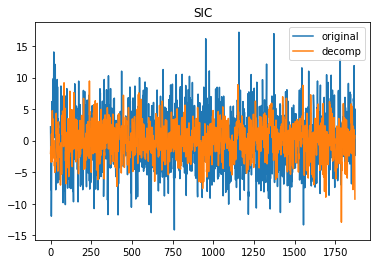

In [157]:
i = 1070
plt.plot(X_var[i,:], label='original')
plt.plot(sic_dcomp[i,:], label='decomp')
plt.title('SIC')
plt.legend()

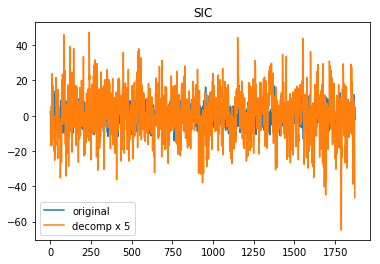

In [158]:
i = 1070
plt.plot(X_var[i,:], label='original')
plt.plot(sic_dcomp[i,:]*5, label='decomp x 5')
plt.title('SIC')
plt.legend()

In [159]:
tas_decomp = np.matmul(E3['tas'],Ptrunc_valid['tas'])
tas_dcomp = limkb.unweight_decompressed_vars(tas_decomp, ['tas'], var_dict, W_all)

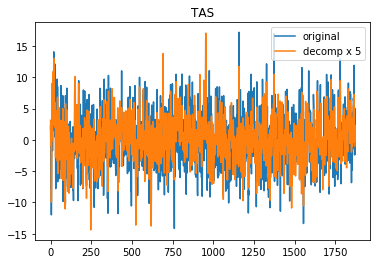

In [160]:
i = 1070
plt.plot(X_var[i,:], label='original')
plt.plot(tas_dcomp[i,:], label='decomp x 5')
plt.title('TAS')
plt.legend()

In [161]:
np.sum(np.var(P_train_valid[0:30,:],axis=1)), np.sum(np.var(P_train_valid[30:60,:],axis=1)), np.sum(np.var(P_train_valid[60:,:],axis=1))

(1.000000000007931, 0.99999999995236, 0.9999999999373522)

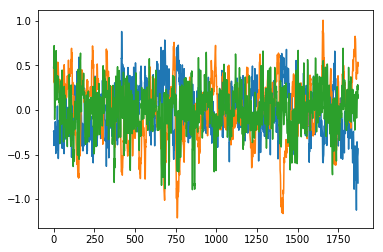

In [162]:
plt.plot(P_train_valid[0,:])
plt.plot(P_train_valid[30,:])
plt.plot(P_train_valid[60,:])

## Run Forecast: 

In [163]:
P_train_valid.shape

(110, 1872)

In [164]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = [0,1,2,3]
#lags = [0,1,2]
ntims = len(lags)
adj = True

nyr_train = nyears_train

if mo == 'all':
    if Insamp==True: 
        print('Performing in sample forecast')
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train[:,0:nyr_train],lags,adjust=adj)
    else: 
        print('Performing out of sample forecast')
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid[:,0:nvalidtimes],lags,adjust=adj)
#        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid[:,70*12:111*12],lags,adjust=adj)
else: 
    if Insamp==True: 
        print('Performing in sample forecast')
        P_train_2d = np.reshape(P_train, (P_train.shape[0],int(P_train.shape[1]/2),2))
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_2d[:,:,0],lags,adjust=adj)
    else: 
        print('Performing out of sample forecast')
#        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid,lags,adjust=adj)
        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid,lags,adjust=adj)
    
#LIM_fcast = LIM_forecast_Gt(LIMd2,P_train_valid,lags)

Performing out of sample forecast
Adjust is True...
NO negative eigenvalue found...
t= 0
t= 1
t= 2
t= 3


## Decompress forecast and validate:

In [165]:
x_forecast_dcomp = np.zeros((len(lags),E3_all.shape[0]+E_sic.shape[0],LIM_fcast['x_forecast'].shape[2]))
nmodes = E3_all.shape[1]

for i,lag in enumerate(lags):
    print('Lag '+ str(lag))
    x_forecast_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(LIM_fcast['x_forecast'][i,:,:],
                                                                nmodes,nmodes_sic,E3_all,
                                                                E_sic,limvars,var_dict,
                                                                W_all,Weights=True,
                                                                sic_separate=sic_separate)

Lag 0
Lag 1
Lag 2
Lag 3


#### Validate all variables: 

In [34]:
validvars = ['tas','tos','sic']
v = {}
validation_stats = {}
lags_test = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#lags_test = [0, 1]
gm_variance_mo = {}
valid_stats_allmo = {}

for k, var in enumerate(validvars):
    X_var, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True)
    
    var_3d = np.reshape(X_var,(X_var.shape[0],1000,12))
    x_anom_var = np.nanvar(var_3d,axis=1,ddof=1)
    gm_x_var = statskb.global_mean(x_anom_var,areacell[areawt_name[var]])
    
    gm_variance_mo[var] = gm_x_var
    
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))
    valid_stats = {}

    for i,lag in enumerate(lags_test):
        print('Lag '+str(lag))
        [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(lag,var,mo,X_var,x_forecast_dcomp,
                                                                     nvalidtimes,var_dict,ntrain,
                                                                     insamp=Insamp)
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))

        [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
         tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
                                                          areacell,areacell_dict,
                                                          areawt_name,month_names,iplot=True)
        
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
    valid_stats['gm_var_ratio'] = gm_var_ratio
    
    validation_stats[var] = valid_stats
    
valid_stats_allmo[mo] = validation_stats

Loading tas
removing climotology...
detrending...
(18432, 12000)
(18432, 12000)
-----------------------------------------------------
completed in 18.351934671401978 seconds
-----------------------------------------------------
Lag 0


KeyError: 'var_inds'

#### Variance across variables across months:

In [ ]:
for var in validvars:
    plt.plot(gm_variance_mo[var], label=var)
    
plt.title('Global mean variance in LM simulation')
plt.ylabel('Variance (%$^2$)')
plt.xticks(np.arange(0,12,1),month_names, rotation=45)
plt.legend()

In [ ]:
for var in validvars:
    plt.plot(gm_variance_mo[var]/gm_variance_mo[var].max(), label=var)
    
plt.title('Global mean variance in LM simulation')
plt.ylabel('Variance (%$^2$)')
plt.xticks(np.arange(0,12,1),month_names, rotation=45)
plt.legend()

#### Validate single variable: 

In [ ]:
lags_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
validvars = ['sic']
v = {}
validation_stats_test = {}

for k, var in enumerate(validvars):
    X_var, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True)
    
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))
    valid_stats_test = {}

    for i,lag in enumerate(lags_test):
        print('Lag '+str(lag))
        [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(lag,var,mo,X_var,x_forecast_dcomp,
                                                                     var_dict,ntrain,insamp=Insamp)
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))
        
#         if lag == 1: 
#             truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
#             truth_error_var = np.where(truth_var<1,0,truth_var)
#             gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])          
    
#         error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
#         truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)

#         ratio = error_var/truth_error_var
        
#         area_shape = areacell[areawt_name[var]].shape
#         gm_var_ratio[i] = statskb.global_mean(ratio[np.isfinite(ratio)],
#                                               np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1]))[np.isfinite(ratio)])

        if lag ==1: 
            truth_error_var = np.nanvar(truth_anom,axis=1,ddof=1)
            area_shape = areacell[areawt_name[var]].shape
            gm_truth_var = statskb.global_mean(truth_error_var[truth_error_var>0],
                                               np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1]))[truth_error_var>0])

        area_shape = areacell[areawt_name[var]].shape
        error_var = np.nanvar(truth_anom-forecast_anom,axis=1,ddof=1)
        gm_error_var = statskb.global_mean(error_var[truth_error_var>0],
                                           np.reshape(areacell[areawt_name[var]],(area_shape[0]*area_shape[1]))[truth_error_var>0])

        gm_var_ratio[i]=gm_error_var/gm_truth_var
#         print(gm_error_var)
#         print(gm_truth_var)
        
    valid_stats_test['gm_var_ratio'] = gm_var_ratio
    validation_stats_test[var] = valid_stats_test

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(7,4))
#fig,axs= plt.subplots(2, 2)

#ax = axs.flatten()

for i,var in enumerate(['sic']):
    ax.plot(np.arange(1,13,1),validation_stats_test[var]['gm_var_ratio'])

#    ax[i].set_ylim(0,1)
    ax.set_xlim(1,10)
#    ax.set_ylim(0,1.1)
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
    ax.grid(axis='both')
    ax.set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)
    ax.set_title(var, fontsize=16)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
    
ax.set_xlabel('lead time (months)', fontsize=14)
ax.set_xlabel('lead time (months)', fontsize=14)

#### Validate SIC: 

In [ ]:
# validvars = ['sic']
# v = {}
# validation_stats = {}

# for k, var in enumerate(validvars):
#     X_var, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True)
    
#     corr_tot = np.zeros((len(lags)))
#     ce_tot = np.zeros((len(lags)))
#     gm_var_ratio = np.zeros((len(lags)))
#     valid_stats = {}

#     for i,lag in enumerate(lags):
#         print('Lag '+str(lag))
#         [truth_anom, forecast_anom] = limbuild.gather_truth_forecast(lag,var,mo,X_var,x_forecast_dcomp,
#                                                                      var_dict,ntrain,insamp=Insamp)
#         print(truth_anom.shape)
#         print(forecast_anom.shape)

#         [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_nh_sic_forecast, 
#          tot_nh_sic_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
#                                                              areacell,areacell_dict,
#                                                              areawt_name,month_names,iplot=True)
        
#     valid_stats['corr_tot'] = corr_tot
#     valid_stats['ce_tot'] = ce_tot
#     valid_stats['gm_var_ratio'] = gm_var_ratio
    
#     validation_stats[var] = valid_stats
    
# valid_stats_allmo[mo] = validation_stats

In [ ]:
# valid_stats['corr_tot'] = corr_tot
# valid_stats['ce_tot'] = ce_tot
# valid_stats['gm_var_ratio'] = gm_var_ratio

# validation_stats[var] = valid_stats

# valid_stats_allmo[mo] = validation_stats

### All limvar plots: 

In [ ]:
mo

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(validation_stats[var]['corr_tot']**2, label='Correlation')
    ax[i].plot(validation_stats[var]['ce_tot'],label='CE')

    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,10)
    ax[i].set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
ax[0].legend(loc='upper right')
ax[2].set_xlabel('lead time (months)', fontsize=14)
ax[3].set_xlabel('lead time (months)', fontsize=14)

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(validation_stats[var]['gm_var_ratio'])

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.2)
    ax[i].set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax[i].grid(axis='both')
    ax[i].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)
    ax[i].set_title(var, fontsize=16)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
    
ax[2].set_xlabel('lead time (months)', fontsize=14)
ax[3].set_xlabel('lead time (months)', fontsize=14)

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(validation_stats_test[var]['gm_var_ratio'])

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,11)
    ax[i].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    ax[i].grid(axis='both')
    ax[i].set_ylabel('GM ratio: \nerror variance to true variance (1 lag only)', fontsize=14)
    ax[i].set_title(var, fontsize=16)
if mo == 'all':
    plt.suptitle('All months', fontsize=16)
else: 
    plt.suptitle(month_names[mo], fontsize=16)
    
ax[2].set_xlabel('lead time (months)', fontsize=14)
ax[3].set_xlabel('lead time (months)', fontsize=14)

### Validation plots: 

In [ ]:
plt.plot(valid_stats['corr_tot']**2, label='Correlation')
plt.plot(valid_stats['ce_tot'],label='CE')
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
plt.xlim(0,4)
plt.xticks([0,1,2,3])
plt.grid(axis='both')
plt.xlabel('lead time (months)')
if mo == 'all':
    plt.title('All months')
else: 
    plt.title(month_names[mo])
plt.legend(loc='lower right')

In [ ]:
valid_stats['corr_tot']**2

In [ ]:
plt.plot(valid_stats['gm_var_ratio'])
plt.axhline(1,linestyle='--', color='k')
plt.xticks([0,1,2,3])
plt.ylim(0,1.1)
plt.xlabel('lead time (months)')
if mo == 'all':
    plt.title('All months')
else: 
    plt.title(month_names[mo])
plt.ylabel('GM ratio: error variance to true variance')

In [ ]:

plt.plot(tot_nh_sic_forecast*1e-6, label='forecast')
plt.plot((tot_nh_sic_truth-np.mean(tot_nh_sic_truth,axis=0))*1e-6, label='truth')
#plt.plot(tot_nh_sic_forecast[3:]*1e-6, label='forecast')
plt.xlim(0,50)
#plt.ylim(-20,20)
plt.legend()

## All months: 

In [ ]:
import pyLIM_1monthLIM_1monthforecast_allmo_042321 as runexp

In [ ]:
# import importlib
# importlib.reload(runexp)
# importlib.reload(limbuild)

In [ ]:
valid_stats_allmo = runexp.run_forecast()

In [ ]:
(valid_stats_allmo.keys())

In [ ]:
valid_stats_1mo = {}

for var in limvars:
    print('Working on '+str(var)+'...')
    corr_plot = np.zeros((11))
    ce_plot = np.zeros((11))
    gm_var_ratio = np.zeros((11))
    v = {}

    for m in range(11):
        corr_plot[m] = valid_stats_allmo[m][var]['corr_tot'][1]**2
        ce_plot[m] = valid_stats_allmo[m][var]['ce_tot'][1]
        gm_var_ratio[m] = valid_stats_allmo[m][var]['gm_var_ratio'][1]

    v['corr2_plot'] = corr_plot
    v['ce_plot'] = ce_plot
    v['gm_var_ratio'] = gm_var_ratio
    valid_stats_1mo[var] = v

In [ ]:
limvars = ['tas','tos','sic']

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(valid_stats_1mo[var]['gm_var_ratio'])

#    ax[i].set_ylim(0,1)
#    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.01)
    ax[i].set_xticks(np.arange(0,12,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)
    ax[i].set_title(var, fontsize=16)

plt.suptitle('All months separate LIM: 1 month lag', fontsize=16)    
ax[2].set_xlabel('Training month', fontsize=14)
ax[3].set_xlabel('Training month', fontsize=14)

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(valid_stats_1mo[var]['corr2_plot'], label='Correlation')
    ax[i].plot(valid_stats_1mo[var]['ce_plot'], label='CE')

#    ax[i].set_ylim(0,1)
#    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.01)
    ax[i].set_xticks(np.arange(0,12,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=16)

plt.suptitle('All months separate LIM: 1 month lag', fontsize=16)    
ax[2].set_xlabel('Training month', fontsize=14)
ax[3].set_xlabel('Training month', fontsize=14)
ax[0].legend()

## Investigate detrending in historical period

In [ ]:
X_var_2d = np.reshape(X_var,(X_var.shape[0],X_var.shape[1]*X_var.shape[2]))

In [ ]:
var = 'sic'
dt = False
v = {}

X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=dt, verbose=True)
units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']

if dt: 
    X_var_in = X_var
else: 
    X_var_in = np.reshape(X_var,(X_var.shape[0],X_var.shape[1]*X_var.shape[2])).T

if var is 'sic':
    sic_tot_arc_hist_rc = statskb.calc_tot_si(X_var_in, areacell[areawt_name[var]], 
                                         units, var_dict[var]['lat'],lat_cutoff=0.0)
else: 
    gm_tas = statskb.global_mean(X_var_in,areacell[areawt_name[var]])

In [ ]:
sic_tot_arc_mo_lm_rc = np.reshape(sic_tot_arc_lm_rc,(int(sic_tot_arc_lm_rc.shape[0]/12),12))
sic_tot_arc_mo_hist_rc = np.reshape(sic_tot_arc_hist_rc,(int(sic_tot_arc_hist_rc.shape[0]/12),12))

fig,ax = plt.subplots(figsize=(8,5))

ax.plot(sic_tot_arc_mo_lm_rc.T[:,1:]/1e6, color='gray', alpha=0.5)
ax.plot(sic_tot_arc_mo_lm_rc.T[:,0]/1e6, color='gray', alpha=1,label='Last Millennium')
ax.plot(sic_tot_arc_mo_hist_rc.T[:,70:110]/1e8, color='purple', alpha=0.2)
ax.plot(sic_tot_arc_mo_hist_rc.T[:,111]/1e8, color='purple', alpha=1,label='Historical (1920-1970)')

# ax.plot(sic_tot_arc_mo_hilm_rc.T[:,157:], color='royalblue', alpha=0.5)
# ax.plot(sic_tot_arc_mo_hilm_rc.T[:,0], color='royalblue', alpha=1,
#         label='Last Millennium (850-1350) + \nHistorical (1850-2005)')
ax.set_ylabel('Arctic sea ice concentration (millions of km$^2)$')
ax.set_xlabel('Month')

plt.title('MPI simulations: de-seasonalized anomalies')
plt.legend(bbox_to_anchor=[1, 1])

In [ ]:
nlm = 500

sic_tot_arc_mo_hilm_rc = np.zeros((nlm+156,12))
sic_tot_arc_mo_hilm_rc[nlm:,:] = sic_tot_arc_mo_hist_rc/1e8
sic_tot_arc_mo_hilm_rc[0:nlm,:] = sic_tot_arc_mo_lm_rc[:nlm,:]/1e6

In [ ]:
sic_tot_arc_mo_lm_rc = np.reshape(sic_tot_arc_lm_rc,(int(sic_tot_arc_lm_rc.shape[0]/12),12))
sic_tot_arc_mo_hist_rc = np.reshape(sic_tot_arc_hist_rc,(int(sic_tot_arc_hist_rc.shape[0]/12),12))

fig,ax = plt.subplots(figsize=(8,5))

ax.plot(sic_tot_arc_mo_lm_rc.T[:,1:]/1e6, color='gray', alpha=0.5)
ax.plot(sic_tot_arc_mo_lm_rc.T[:,0]/1e6, color='gray', alpha=1,label='Last Millennium')
ax.plot(sic_tot_arc_mo_hist_rc.T[:,1:]/1e8, color='purple', alpha=0.2)
ax.plot(sic_tot_arc_mo_hist_rc.T[:,0]/1e8, color='purple', alpha=1,label='Historical')

ax.plot(sic_tot_arc_mo_hilm_rc.T[:,157:], color='royalblue', alpha=0.5)
ax.plot(sic_tot_arc_mo_hilm_rc.T[:,0], color='royalblue', alpha=1,
        label='Last Millennium (850-1350) + \nHistorical (1850-2005)')
ax.set_ylabel('Arctic sea ice concentration (millions of km$^2)$')
ax.set_xlabel('Month')

plt.title('MPI simulations: de-seasonalized anomalies')
plt.legend(bbox_to_anchor=[1, 1])

In [ ]:
sic_tot_arc_mo_lm = np.reshape(sic_tot_arc_lm,(int(sic_tot_arc_lm.shape[0]/12),12))
sic_tot_arc_mo_lm.shape

In [ ]:
sic_tot_arc_mo_lm = np.reshape(sic_tot_arc_lm,(int(sic_tot_arc_lm.shape[0]/12),12))

fig,ax = plt.subplots(figsize=(8,5))

ax.plot(sic_tot_arc_mo_lm.T[:,1:], color='gray', alpha=0.5)
ax.plot(sic_tot_arc_mo_lm.T[:,0], color='gray', alpha=0.5,label='Last Millennium')
ax.plot(sic_tot_arc_mo.T[:,1:]/100, color='purple', alpha=0.2)
ax.plot(sic_tot_arc_mo.T[:,0]/100, color='purple', alpha=0.2,label='Historical')

ax.set_ylabel('Arctic sea ice concentration (km$^2)$')
ax.set_xlabel('Month')

plt.title('MPI simulations: seasonal cycle in time')
plt.legend()

In [ ]:
# sic_tot_arc_og = sic_tot_arc
# gm_tas_og = gm_tas

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))

ax2=ax.twinx()

ax.plot(var_dict_valid['tas']['time'],sic_tot_arc_dt, color='c', zorder=1, label='sea ice area')
ax2.plot(var_dict_valid['tas']['time'],gm_tas_dt, color='crimson', zorder=0, label='global mean temp')

ax.set_ylabel('Millions of km$^2$')
ax2.set_ylabel('Degrees Celcius$')
ax.set_xlabel('Time')

ax2.legend(loc='lower right')
ax.legend(loc='lower left')
plt.title('MPI Historical simulation: Linearly detrended')

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))

ax2=ax.twinx()

ax.plot(var_dict_valid['tas']['time'],sic_tot_arc_og, color='c', zorder=1, label='sea ice area')
ax2.plot(var_dict_valid['tas']['time'],gm_tas_og, color='crimson', zorder=0, label='global mean temp')

ax.set_ylabel('Millions of km$^2$')
ax2.set_ylabel('Degrees Celcius$')
ax.set_xlabel('Time')

ax2.legend(loc='lower right')
ax.legend(loc='lower left')
plt.title('MPI Historical simulation: No detrending')

In [ ]:
fig,ax = plt.subplots()

ax2=ax.twinx()

ax2.plot(sic_tot_arc, color='c', zorder=1)
ax.plot(gm_tas, color='crimson', zorder=0)

### All months: break up my month

In [166]:
x_forecast_dcomp_mo = np.reshape(x_forecast_dcomp, (x_forecast_dcomp.shape[0], x_forecast_dcomp.shape[1], 
                                                    int(x_forecast_dcomp.shape[2]/12),12))

x_forecast_dcomp_mo.shape

(4, 131072, 156, 12)

In [167]:
 x_forecast_dcomp_mo.shape, x_forecast_dcomp.shape, (x_forecast_dcomp.shape[0], x_forecast_dcomp.shape[1], 
                                                    int(x_forecast_dcomp.shape[2]/12),12)

((4, 131072, 156, 12), (4, 131072, 1872), (4, 131072, 156, 12))

Loading tas
removing climotology...
detrending...
(18432, 1872)
(18432, 1872)
-----------------------------------------------------
completed in 3.8044023513793945 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
nyears_valid 0
nyears_train 156
Validating against month 0
Truth_anom shape: (18432, 156)
Forecast_anom shape: (18432, 156)


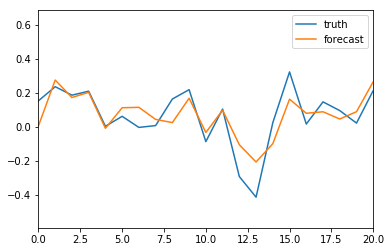

Month 1
Trained using month 1...
nyears_valid 0
nyears_train 156
Validating against month 1
Truth_anom shape: (18432, 156)
Forecast_anom shape: (18432, 156)


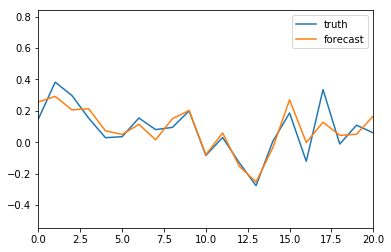

Month 2
Trained using month 2...
nyears_valid 0
nyears_train 156
Validating against month 2
Truth_anom shape: (18432, 156)
Forecast_anom shape: (18432, 156)


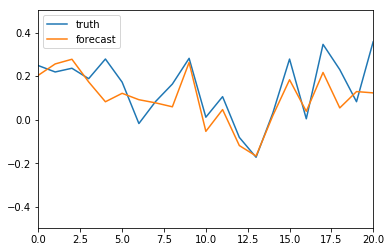

Month 3
Trained using month 3...
nyears_valid 0
nyears_train 156
Validating against month 3
Truth_anom shape: (18432, 156)
Forecast_anom shape: (18432, 156)


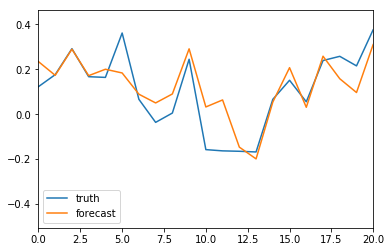

Month 4
Trained using month 4...
nyears_valid 0
nyears_train 156
Validating against month 4
Truth_anom shape: (18432, 156)
Forecast_anom shape: (18432, 156)


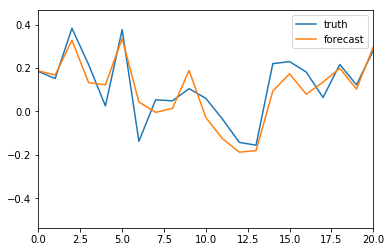

Month 5
Trained using month 5...
nyears_valid 0
nyears_train 156
Validating against month 5
Truth_anom shape: (18432, 156)
Forecast_anom shape: (18432, 156)


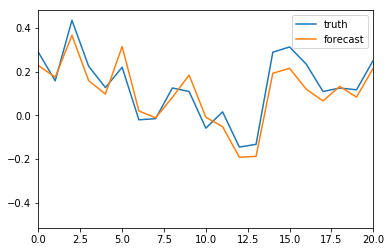

Month 6
Trained using month 6...
nyears_valid 0
nyears_train 156
Validating against month 6
Truth_anom shape: (18432, 156)
Forecast_anom shape: (18432, 156)


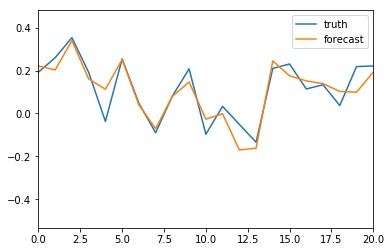

Month 7
Trained using month 7...
nyears_valid 0
nyears_train 156
Validating against month 7
Truth_anom shape: (18432, 156)
Forecast_anom shape: (18432, 156)


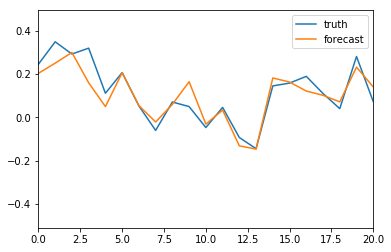

Month 8
Trained using month 8...
nyears_valid 0
nyears_train 156
Validating against month 8
Truth_anom shape: (18432, 156)
Forecast_anom shape: (18432, 156)


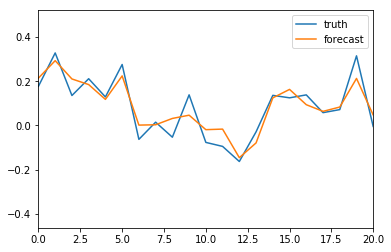

Month 9
Trained using month 9...
nyears_valid 0
nyears_train 156
Validating against month 9
Truth_anom shape: (18432, 156)
Forecast_anom shape: (18432, 156)


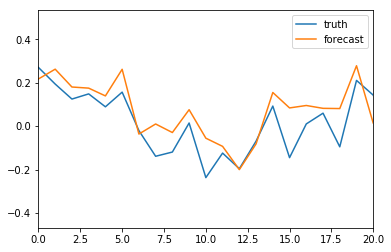

Month 10
Trained using month 10...
nyears_valid 0
nyears_train 156
Validating against month 10
Truth_anom shape: (18432, 156)
Forecast_anom shape: (18432, 156)


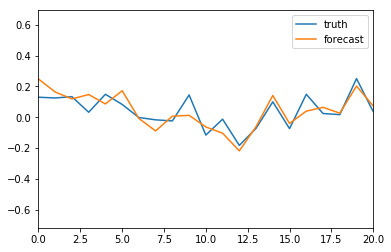

Loading tos
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 12.448405504226685 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
nyears_valid 0
nyears_train 156
Validating against month 0
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


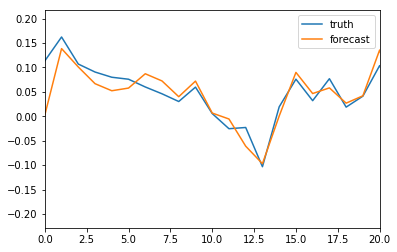

Month 1
Trained using month 1...
nyears_valid 0
nyears_train 156
Validating against month 1
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


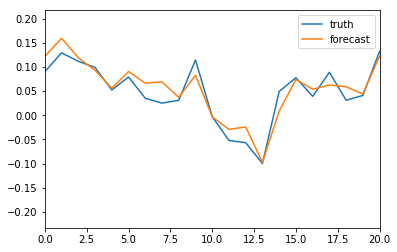

Month 2
Trained using month 2...
nyears_valid 0
nyears_train 156
Validating against month 2
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


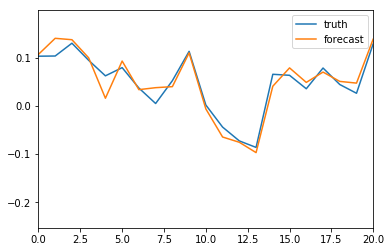

Month 3
Trained using month 3...
nyears_valid 0
nyears_train 156
Validating against month 3
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


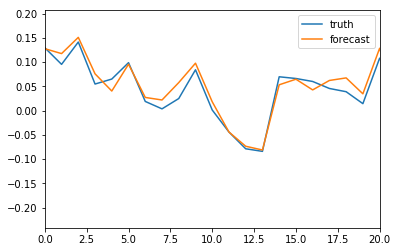

Month 4
Trained using month 4...
nyears_valid 0
nyears_train 156
Validating against month 4
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


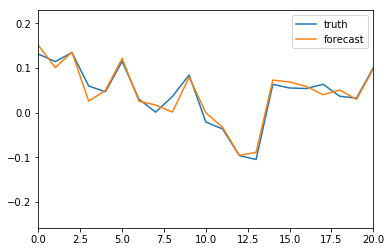

Month 5
Trained using month 5...
nyears_valid 0
nyears_train 156
Validating against month 5
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


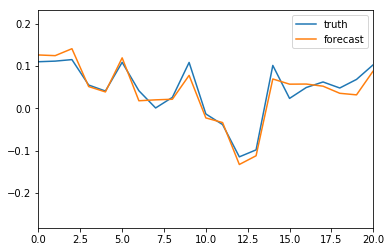

Month 6
Trained using month 6...
nyears_valid 0
nyears_train 156
Validating against month 6
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


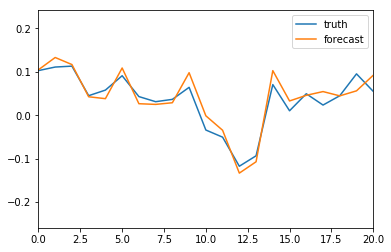

Month 7
Trained using month 7...
nyears_valid 0
nyears_train 156
Validating against month 7
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


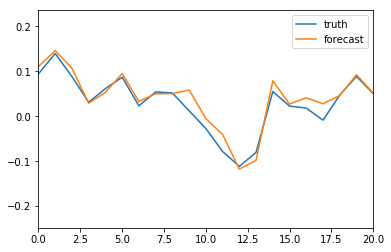

Month 8
Trained using month 8...
nyears_valid 0
nyears_train 156
Validating against month 8
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


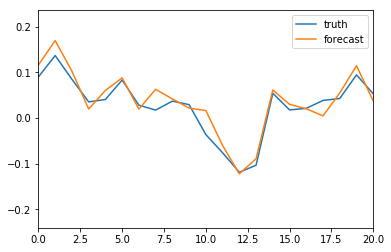

Month 9
Trained using month 9...
nyears_valid 0
nyears_train 156
Validating against month 9
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


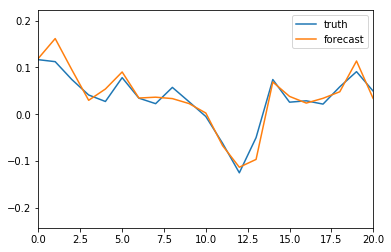

Month 10
Trained using month 10...
nyears_valid 0
nyears_train 156
Validating against month 10
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


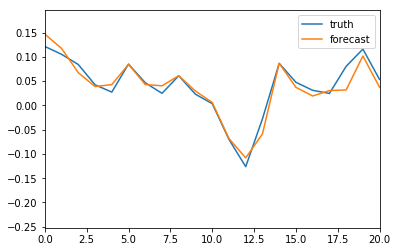

Loading sic
removing climotology...
detrending...
(56320, 1872)
(56320, 1872)
-----------------------------------------------------
completed in 11.978363752365112 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
nyears_valid 0
nyears_train 156
Validating against month 0
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


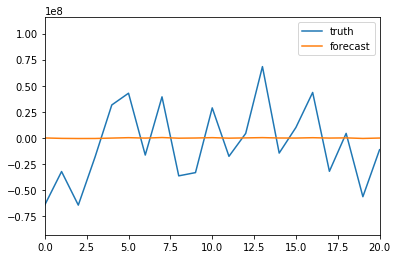

Month 1
Trained using month 1...
nyears_valid 0
nyears_train 156
Validating against month 1
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


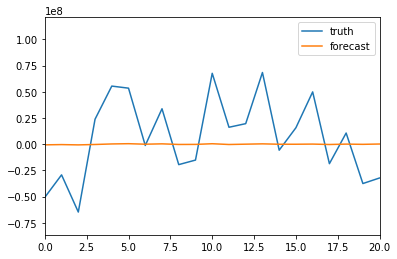

Month 2
Trained using month 2...
nyears_valid 0
nyears_train 156
Validating against month 2
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


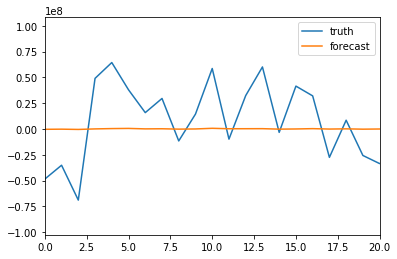

Month 3
Trained using month 3...
nyears_valid 0
nyears_train 156
Validating against month 3
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


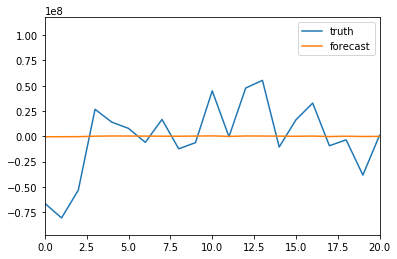

Month 4
Trained using month 4...
nyears_valid 0
nyears_train 156
Validating against month 4
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


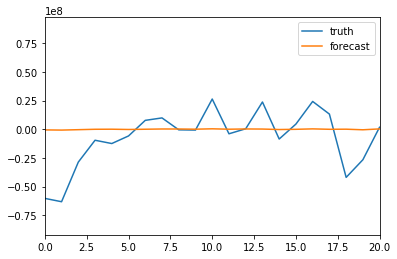

Month 5
Trained using month 5...
nyears_valid 0
nyears_train 156
Validating against month 5
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


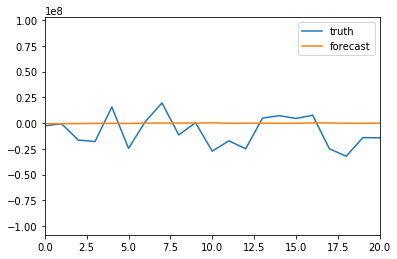

Month 6
Trained using month 6...
nyears_valid 0
nyears_train 156
Validating against month 6
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


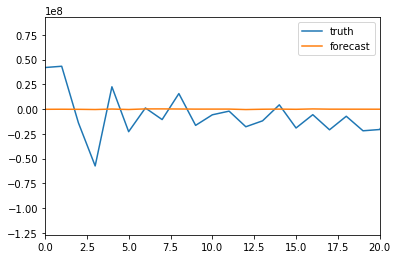

Month 7
Trained using month 7...
nyears_valid 0
nyears_train 156
Validating against month 7
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


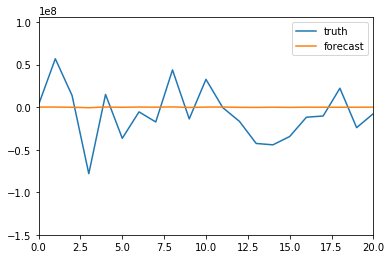

Month 8
Trained using month 8...
nyears_valid 0
nyears_train 156
Validating against month 8
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


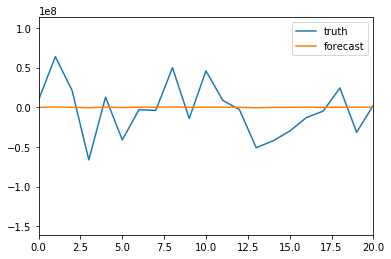

Month 9
Trained using month 9...
nyears_valid 0
nyears_train 156
Validating against month 9
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


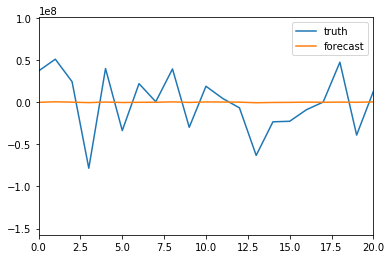

Month 10
Trained using month 10...
nyears_valid 0
nyears_train 156
Validating against month 10
Truth_anom shape: (56320, 156)
Forecast_anom shape: (56320, 156)


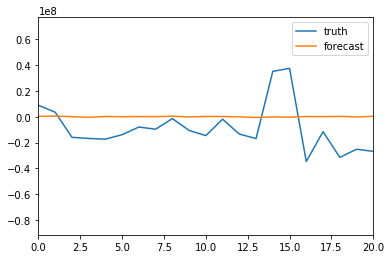

In [170]:
validvars = ['tas','tos','sic']
# validvars = ['psl']
months=[0,1,2,3,4,5,6,7,8,9,10]
lag=1
validation_stats = {}

for k, var in enumerate(validvars):
    valid_stats = {}
    v = {}
    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True)
    
    corr_tot = np.zeros((len(months)))
    ce_tot = np.zeros((len(months)))
    gm_var_ratio = np.zeros((len(months)))
    
    for i,m in enumerate(months):
        print('Month '+str(m))
        [truth_anom, forecast_anom] = gather_truth_forecast_allmo(lag,var,m,X_var,
                                                                  x_forecast_dcomp_mo[:,:,:,m],
                                                                  var_dict,ntrain_valid,insamp=False)
        print('Truth_anom shape: '+str(truth_anom.shape))
        print('Forecast_anom shape: '+str(forecast_anom.shape))

#         [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
#          tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom[:,70:111], forecast_anom, var_dict,
#                                                           areacell,areacell_dict,
#                                                           areawt_name,month_names,iplot=True)
        [corr_tot[i], ce_tot[i], gm_var_ratio[i], tot_var_forecast, 
         tot_var_truth] = limbuild.calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,
                                                          areacell,areacell_dict,
                                                          areawt_name,month_names,iplot=True)
        
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
    valid_stats['gm_var_ratio'] = gm_var_ratio
    
    validation_stats[var] = valid_stats
    
    del X_var

In [171]:
for i,var in enumerate(validvars):
    print(var +': ' + str(np.mean(validation_stats[var]['corr_tot']**2)))

tas: 0.797154737678277
tos: 0.9318533245206088
sic: 0.6267186580395673


In [172]:
for i,var in enumerate(validvars):
    print(var +': ' + str(np.mean(validation_stats[var]['corr_tot']**2)))

tas: 0.797154737678277
tos: 0.9318533245206088
sic: 0.6267186580395673


In [173]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov']

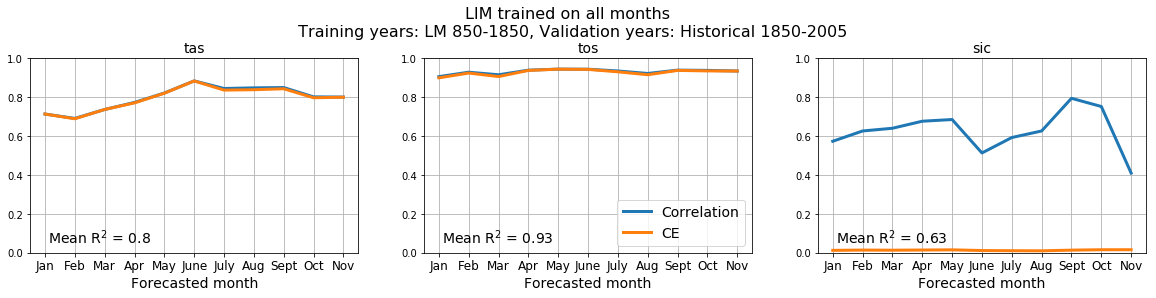

In [174]:
fig,axs = plt.subplots(1,3,figsize=(20,4))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(['tas','tos','sic']):
    ax[i].plot(validation_stats[var]['corr_tot']**2, label='Correlation',linewidth=3.0)
    ax[i].plot(validation_stats[var]['ce_tot'],label='CE',linewidth=3.0)

    ax[i].set_ylim(0,1)
#     ax[i].set_xlim(0,10)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
#                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: LM '+
                  str(850)+'-'+str(int(850+ntrain_valid*1000))+
                                   ', Validation years: Historical 1850-2005'), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[1].legend(loc='lower right', fontsize=14)
ax[2].set_xlabel('Forecasted month', fontsize=14)
ax[1].set_xlabel('Forecasted month', fontsize=14)
ax[0].set_xlabel('Forecasted month', fontsize=14)

plt.subplots_adjust(top=0.8)

In [175]:
(12000*0.3)/12

300.0

KeyError: 'psl'

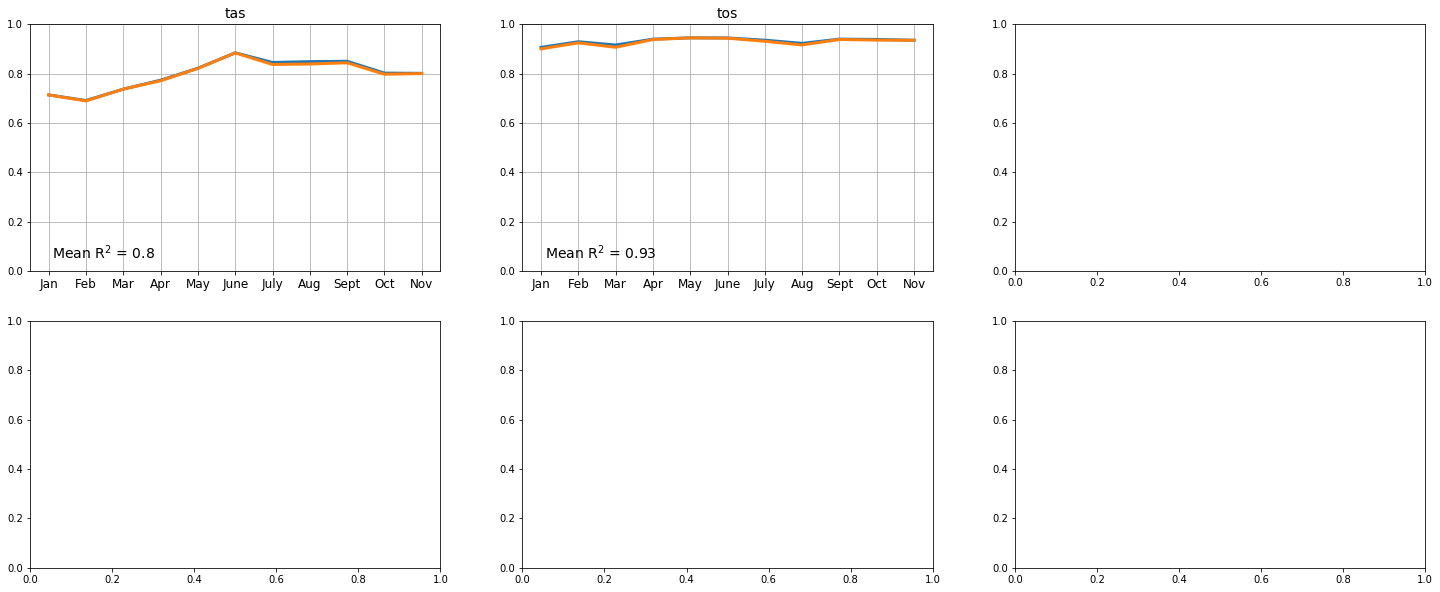

In [176]:
fig,axs = plt.subplots(2,3,figsize=(25,10))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(['tas','tos','psl','sit','sic']):
    ax[i].plot(validation_stats[var]['corr_tot']**2, label='Correlation',linewidth=3.0)
    ax[i].plot(validation_stats[var]['ce_tot'],label='CE',linewidth=3.0)

    ax[i].set_ylim(0,1)
#     ax[i].set_xlim(0,10)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: '+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
else:     
    plt.suptitle(('LIM trained on all months \n Training years: Historical 1850-2005, Validation years: Historical '+
                  str(850)+'-'+str(int(850+ntrain_valid*1000))), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[1].legend(loc='lower right', fontsize=14)
ax[-1].set_xlabel('Forecasted month', fontsize=14)
ax[-2].set_xlabel('Forecasted month', fontsize=14)
ax[-3].set_xlabel('Forecasted month', fontsize=14)

#plt.subplots_adjust(top=0.8)

In [177]:
for i,var in enumerate(limvars):
    print(var +': ' + str(np.mean(validation_stats[var]['gm_var_ratio'])))

tas: 0.8515376743530456
tos: 0.6362311327019743
sic: 0.6281107512548068


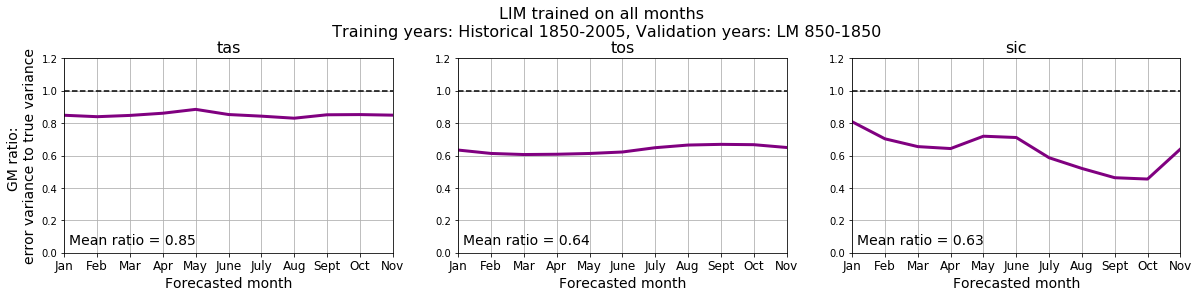

In [178]:
fig,axs = plt.subplots(1,3,figsize=(20,4))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(['tas','tos','sic']):
    ax[i].plot(validation_stats[var]['gm_var_ratio'],linewidth=3.0, color='purple')

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.2)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=16)
    ax[i].text(0.15,0.05, ("Mean ratio = "+str(np.round(np.mean(validation_stats[var]['gm_var_ratio']),2))),
               fontsize=14)
    ax[i].axhline(1.0,color='k',linestyle='--')

if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
#                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: Historical 1850-2005, Validation years: LM '+
                  str(850)+'-'+str(int(850+ntrain_valid*1000))), fontsize=16)
    
ax[2].set_xlabel('Forecasted month', fontsize=14)
ax[1].set_xlabel('Forecasted month', fontsize=14)
ax[0].set_xlabel('Forecasted month', fontsize=14)
ax[0].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)

plt.subplots_adjust(top=0.8)

In [ ]:
fig,axs = plt.subplots(2,3,figsize=(25,10))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(['tas','tos','psl','sit','sic']):
    ax[i].plot(validation_stats[var]['gm_var_ratio'],linewidth=3.0, color='purple')

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.2)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=16)
    ax[i].text(0.15,0.05, ("Mean ratio = "+str(np.round(np.mean(validation_stats[var]['gm_var_ratio']),2))),
               fontsize=14)
    ax[i].axhline(1.0,color='k',linestyle='--')

if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: '+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
else:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
                  str(int(850+ntrain*1000))+', Validation years: '+
                  str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    
ax[-1].set_xlabel('Forecasted month', fontsize=14)
ax[-2].set_xlabel('Forecasted month', fontsize=14)
ax[0].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)
ax[-2].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)


In [ ]:
np.nansum((truth_anom - np.nanmean(truth_anom,axis=1)[:,np.newaxis]),axis=1).shape

In [ ]:
plt.plot(x_var_dt[1061,:])
plt.plot(x_var[1061,:])

In [ ]:
error_sic_2d = np.reshape(error_var, (var_dict['sic']['lat'].shape))
plt.pcolormesh(error_sic_2d)
plt.colorbar()
plt.title('Error Variance: SIC')

In [ ]:
error_sic_2d = np.reshape(truth_error_var, (var_dict['sic']['lat'].shape))
plt.pcolormesh(error_sic_2d)
plt.colorbar()
plt.title('Truth Variance: SIC')

In [ ]:
x = np.array([1,3,2,5,9,11,13,2,6])
y = np.array([3,4,9,8,12,1,11,6,15])

In [ ]:
plt.plot(x)
plt.plot(y)

In [ ]:
np.var(x-y)

In [ ]:
np.sum((x-y)**2)